# Importing Dependencies

In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import os

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.layers import Conv2DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.utils import normalize

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path = "/home/robin/Documents/bdd100k_images_10k/bdd100k/images/10k/train/"

train_mask_path = "/home/robin/Documents/bdd100k_sem_seg_labels_trainval/bdd100k/labels/sem_seg/masks/train/"

In [4]:
SIZE = 224

In [5]:
train_img_data = []

train_mask_data = []

In [6]:
train_images = os.listdir(train_path)

sorted_train_images = sorted(train_images)

sorted_train_images[:5]

['0004a4c0-d4dff0ad.jpg',
 '00054602-3bf57337.jpg',
 '00067cfb-e535423e.jpg',
 '00091078-59817bb0.jpg',
 '0010bf16-a457685b.jpg']

In [7]:
for i, image_name in enumerate(sorted_train_images):    
    if (image_name.split('.')[1] == 'jpg'):
        #print(image_directory+image_name)
        image = cv2.imread(train_path+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_img_data.append(np.array(image))

In [8]:
# for training masks

train_masks = os.listdir(train_mask_path)

sorted_train_masks = sorted(train_masks)

sorted_train_masks[:5]

['0004a4c0-d4dff0ad.png',
 '00054602-3bf57337.png',
 '00067cfb-e535423e.png',
 '00091078-59817bb0.png',
 '0010bf16-a457685b.png']

In [9]:
for i, image_name in enumerate(sorted_train_masks):
    if (image_name.split('.')[1] == 'png'):
        image = cv2.imread(train_mask_path+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_mask_data.append(np.array(image))

In [10]:
# Normalize images

train_img_data = np.expand_dims(normalize(np.array(train_img_data), axis=1),3)

In [11]:
# rescale mask to 0 to 1.

train_mask_data = np.expand_dims((np.array(train_mask_data)),3) /255.

In [12]:
len(train_img_data)

7000

In [19]:
X_train,X_test,y_train,y_test =train_test_split(train_img_data, train_mask_data,test_size = 0.25, random_state = 0)

ValueError: Found input variables with inconsistent numbers of samples: [10584, 7000]

In [21]:
train_img_data = []

In [22]:
train_path = "/home/robin/Documents/bdd100k_images_10k/bdd100k/images/10k/train/"

In [23]:
train_images = os.listdir(train_path)

sorted_train_images = sorted(train_images)

print(len(sorted_train_images))

7000


In [24]:
for i, image_name in enumerate(sorted_train_images):    
    if (image_name.split('.')[1] == 'jpg'):
        image = cv2.imread(train_path+image_name, 0)
        image = Image.fromarray(image)
        image = image.resize((SIZE, SIZE))
        train_img_data.append(np.array(image))

In [25]:
print(len(sorted_train_images))

7000


In [26]:
# Normalize images

train_img_data = np.expand_dims(normalize(np.array(train_img_data), axis=1),3)

In [13]:
X_train,X_test,y_train,y_test =train_test_split(train_img_data, train_mask_data,test_size = 0.25, random_state = 0)

In [14]:
X_train.shape, X_test.shape

((5250, 224, 224, 1), (1750, 224, 224, 1))

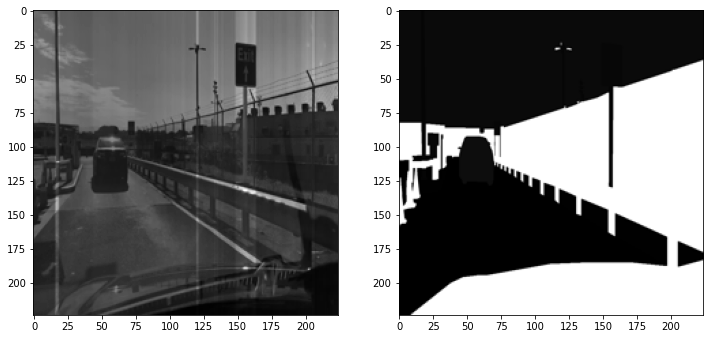

In [15]:
#Sanity check, view few images

import random
import numpy as np

image_number = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[image_number], (224, 224)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[image_number], (224, 224)), cmap='gray')

plt.show()

In [16]:
IMG_HEIGHT = train_img_data.shape[1]
IMG_WIDTH  = train_img_data.shape[2]
IMG_CHANNELS = train_img_data.shape[3]

In [17]:
print(IMG_HEIGHT)
print(IMG_WIDTH)
print(IMG_CHANNELS)

224
224
1


In [18]:
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    #Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    return model

In [19]:
def get_model():
    return simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [21]:
model = get_model()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 224, 224, 16  160         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_9 (Dropout)            (None, 224, 224, 16  0           ['conv2d_19[0][0]']              
                                )                                                           

In [22]:
#initialize our callbacks

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

model_path = ("road_segmentation_u_net.h5")
checkpoint = ModelCheckpoint(model_path,
                             monitor = "val_loss",
                             mode = "min",
                             save_best_only = True,
                             verbose = 1)

earlystop = EarlyStopping(monitor = "val_loss",
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

callbacks = [checkpoint, earlystop]

In [ ]:
history = model.fit(X_train, y_train, 
                    batch_size = 32, 
                    verbose=1, 
                    epochs=2,
                    callbacks = callbacks,
                    validation_data=(X_test, y_test), 
                    shuffle=False)

model.save('road_segmentation_u_net.h5')

2022-06-10 03:15:24.623224: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1053696000 exceeds 10% of free system memory.
